In [77]:
import pickle


with open('../scenario-properties-collision.pkl', 'rb') as f:
    data = pickle.load(f)

AttributeError: Can't get attribute 'SpeciesCollisionPair' on <module 'utils.collisions.collisions_elliptical' from 'c:\\Users\\IT\\Documents\\UCL\\pyssem\\pyssem\\utils\\collisions\\collisions_elliptical.py'>

In [33]:
from sympy import symbols, Matrix, pi, S, Expr, zeros

class SpeciesPairClass:
    def __init__(self, species1, species2, gammas, source_sinks, scen_properties, fragsMadeDV=None):
        """
        This makes the species pair class associated with a collision between species1
        and species2. It will then create equations for the collision probability modifiers
        in gamma and the species in source_sinks.

        If the symbolic argument "n_f" is passed, it will be replaced with the n_f value
        for a collision involved species1 and species2 at each dv in scen_properties.v_imp2

        Other species will gain from a collision - e.g. debris. 

        Args:
            species1 (Species): The first species in the collision
            species2 (Species): The second species in the collision
            gammas (np.ndarray): The collision probability modifiers for each species in source_sinks.
            A scalar or a N x M matrix, where N is the number of altitude bins and M is the number of species
            with population addition/subtractions where this collision types occur. 
            source_sinks (list): A list of species that are either sources or sinks in the collision
            scen_properties (ScenarioProperties): The scenario properties object
        """
        if gammas.shape[1] != len(source_sinks):
            raise ValueError("Gammas and source_sinks must be the same length")
    
        # As species is a dictionary, it needs to be flatted first        
        all_species = [species for category in scen_properties.species.values() for species in category]

        self.name = f"species_pair({species1.sym_name}, {species2.sym_name})"
        self.species1 = species1
        self.species2 = species2

        meter_to_km = 1 / 1000

        # Square of impact parameter
        self.sigma = (species1.radius * meter_to_km + \
                      species2.radius * meter_to_km) ** 2

        # Scaling based on v_imp, shell volume, and object radii
        self.phi = pi * scen_properties.v_imp2 / (scen_properties.V * meter_to_km**3) * self.sigma * S(86400) * S(365.25)

        # Check if collision is catastrophic
        self.catastrophic = self.is_catastrophic(species1.mass, species2.mass, scen_properties.v_imp2)

        # Fragment generation equations
        M1 = species1.mass
        M2 = species2.mass
        LC = scen_properties.LC
        
        nf = zeros(len(scen_properties.v_imp2), 1)

        for i, dv in enumerate(scen_properties.v_imp2):
            if self.catastrophic[i]:
                # number of fragments generated during a catastrophic collision (NASA standard break-up model). M is the sum of the mass of the objects colliding in kg
                n_f_catastrophic = 0.1 * LC**(-S(1.71)) * (M1 + M2)**(S(0.75))
                nf[i] = n_f_catastrophic
            else:
                # number of fragments generated during a non-catastrophic collision (improved NASA standard break-up model: takes into account the kinetic energy). M is the mass of the less massive object colliding in kg
                n_f_damaging = 0.1 * LC**(-S(1.71)) * (min(M1, M2) * dv**2)**(S(0.75))
                nf[i] = n_f_damaging

        self.nf = nf.transpose() 
            
        self.gammas = gammas
        self.source_sinks = source_sinks
        self.eqs = Matrix(scen_properties.n_shells, len(all_species), lambda i, j: 0)

        if isinstance(self.phi, (int, float, Expr)):
            phi_matrix = Matrix([self.phi] * len(gamma))
        else:
            phi_matrix = Matrix(self.phi)

        if scen_properties.fragment_spreading:
            product_sym = species1.sym.multiply_elementwise(species2.sym).T



        # Go through each gamma (which modifies collision for things like collision avoidance, or fragmentation into 
        # derelicsts, etc.) We increment the eqs matrix with the gamma * phi * species1 * species2.
        for i in range(gammas.shape[1]):
            gamma = gammas[:, i]
            eq_index = None
            for idx, spec in enumerate(all_species):
                if spec.sym_name == source_sinks[i].sym_name:
                    eq_index = idx
                    break

            if eq_index is None:
                raise ValueError(f"Equation index not found for {source_sinks[i].sym_name}")
            
            n_f = symbols(f'n_f:{scen_properties.n_shells}')

            if scen_properties.fragment_spreading:
                if i < 2:  # As first two columns are the reduction of the species in the collision (i.e -1)
                    eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                else:  # Debris generated from collision
                    try:                         
                        fragsMadeDVcurrentDeb = fragsMadeDV[:, i-2] # First two rows are the reduction of the species in the collision (i.e -1)

                        # Create the 2D fragment matrix with circular shifts
                        fragsMade2D_list = [np.roll(fragsMadeDVcurrentDeb, shift) for shift in range(scen_properties.n_shells + 1)]
                        fragsMade2D = np.column_stack(fragsMade2D_list)

                        # Adjust the slicing to match MATLAB's slicing
                        fragsMade2D = fragsMade2D[scen_properties.n_shells:, :scen_properties.n_shells]  # from N_shell:end for rows, 1:N_shell for columns
                        fragsMade2D_sym = Matrix(fragsMade2D)

                        # Use the species product matrix and repeat it for each shell, this will allow all symbolic variables to be affected across all shells
                        rep_mat_sym = Matrix.vstack(*[product_sym for _ in range(scen_properties.n_shells)])

                        # Perform element-wise multiplication
                        sum_ = fragsMade2D_sym.multiply_elementwise(rep_mat_sym)
                                          
                        # Sum the columns of the multiplied_matrix
                        sum_matrix = Matrix([sum(sum_[row, :]) for row in range(sum_.shape[0])])

                        # Multiply gammas, phi, and the sum_matrix element-wise
                        eq = -gammas[:, 0].multiply_elementwise(phi_matrix).multiply_elementwise(sum_matrix)

                        # Plotting (similar to MATLAB's imagesc)
                        # plt.figure(100)
                        # plt.clf()
                        # plt.imshow(fragsMade2D, aspect='auto', interpolation='none')
                        # plt.colorbar()
                        # plt.title(f"{self.name} for {source_sinks[i].sym_name}", fontsize=10)
                        # plt.gca().invert_yaxis()
                        # plt.savefig(f"figures/frag_spread/fragsMade2D_{source_sinks[i].sym_name}.png")
                        # print(f"eq: {eq}")
                    except Exception as e:
                        if fragsMadeDV == 0:
                            eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                            continue
                        # print(f"Error in creating debris matrix: {e}")
            else:
                eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                
            for j, val in enumerate(self.nf):
                eq = eq.subs(n_f[j], val)

            self.eqs[:, eq_index] = self.eqs[:, eq_index] + eq  
            


array([[0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

N_500kg_e0.018750000000000003_sh_6
N_500kg_e0.08125000000000002_sh_6


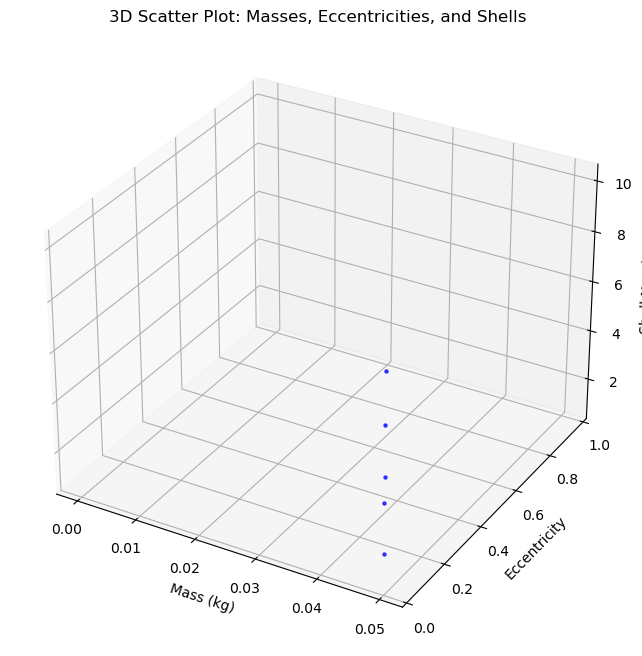

In [64]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

fragments = data.results[5011].fragments[0]

# Loop through the n_shells and fragments
for i in range(10):
    for j in range(fragments.shape[2]):  # Loop through the fragments
        mass = fragments[i, 0, j]
        ecc = fragments[i, 1, j]
        
        # Plot each fragment: x = mass, y = eccentricity, z = n_shell
        ax.scatter(mass, ecc, i + 1, s=np.log(mass + 1) * 100, c='b' if mass < 1 else 'r', alpha=0.7)

# Set plot labels
ax.set_title('3D Scatter Plot: Masses, Eccentricities, and Shells')
ax.set_xlabel('Mass (kg)')
ax.set_ylabel('Eccentricity')
ax.set_zlabel('Shell Number')
ax.set_ylim([0, 1])

# Show plot
plt.show()

In [ ]:
import numpy as np
from utils.collisions.collisions import func_Am, func_dv

def frag_col_SBM_vec_lc2(ep, p1_in, p2_in, param, LB):
    # Ensure p1_mass > p2_mass, or p1_radius > p2_radius if p1_mass == p2_mass
    if p1_in[0] < p2_in[0] or (p1_in[0] == p2_in[0] and p1_in[1] < p2_in[1]):
        p1_in, p2_in = p2_in, p1_in
    
    p1_mass, p1_radius = p1_in[0], p1_in[1]
    p1_r, p1_v = np.array(p1_in[2:5]), np.array(p1_in[5:8])
    p1_objclass = p1_in[8]
    
    p2_mass, p2_radius = p2_in[0], p2_in[1]
    p2_r, p2_v = np.array(p2_in[2:5]), np.array(p2_in[5:8])
    p2_objclass = p2_in[8]
    
    dv = np.linalg.norm(p1_v - p2_v)
    catastrophRatio = (p2_mass * (dv * 1000)**2) / (2 * p1_mass * 1000)
    
    # If the specific energy is < 40 J/g: non-catastrophic collision
    if catastrophRatio < 40:
        M = p2_mass * dv**2
        isCatastrophic = False
    else:
        M = p1_mass + p2_mass
        isCatastrophic = True

    # Number of fragments, using Johnson et al. distribution
    num = int(np.floor(0.1 * M**0.75 * LB**-1.71 - 0.1 * M**0.75 * min([1, 2 * p1_radius])**-1.71))

    dd_edges = np.logspace(np.log10(LB), np.log10(min([1, 2 * p1_radius])), 200)
    log10_dd = np.log10(dd_edges)
    dd_means = 10**(log10_dd[:-1] + np.diff(log10_dd) / 2)

    nddcdf = 0.1 * M**0.75 * dd_edges**-1.71
    ndd = np.maximum(0, -np.diff(nddcdf))
    floor_ndd = np.floor(ndd)
    rand_sampling = np.random.rand(len(ndd))
    add_sampling = rand_sampling > (1 - (ndd - floor_ndd))
    d_pdf = np.repeat(dd_means, floor_ndd + add_sampling)
    d = np.random.permutation(d_pdf)

    # Calculate mass of fragments and areas
    A = 0.556945 * d**2.0047077
    Am = func_Am(d, p1_objclass)  # Placeholder for Am function
    m = A / Am

    if np.sum(m) < M:
        if isCatastrophic:
            # Catastrophic fragmentation logic
            largeidx = (d > p2_radius * 2) & (d < p1_radius * 2)
            m_assigned_large = np.sum(m[largeidx])
            
            if m_assigned_large > p1_mass:
                idx_large = np.where(largeidx)[0]
                dord1 = np.argsort(m[idx_large])
                cumsum_m1 = np.cumsum(m[idx_large[dord1]])
                lastidx1 = np.max(np.where(cumsum_m1 < p1_mass)[0])
                remove_idx = idx_large[dord1[lastidx1 + 1:]]
                m = np.delete(m, remove_idx)
                d = np.delete(d, remove_idx)
                A = np.delete(A, remove_idx)
                Am = np.delete(Am, remove_idx)
                largeidx = np.delete(largeidx, remove_idx)
                m_assigned_large = cumsum_m1[lastidx1]
            
            mass_max_small = min([p2_mass, m_assigned_large])

            smallidx_temp = np.where(~largeidx)[0]
            dord = np.argsort(m[smallidx_temp])
            cumsum_m = np.cumsum(m[smallidx_temp[dord]])
            lastidx_small = np.max(np.where(cumsum_m <= mass_max_small)[0])
            smallidx = np.zeros_like(d, dtype=bool)
            smallidx[smallidx_temp[dord[:lastidx_small]]] = 1
            m_assigned_small = np.sum(m[smallidx])

            m_remaining_large = p1_mass - m_assigned_large
            m_remaining_small = p2_mass - m_assigned_small
            m_remaining = [m_remaining_large, m_remaining_small]

            # Remaining fragments assignment
            m_remSum = M - np.sum(m)
            remDist = np.random.rand(np.random.randint(2, 8))
            m_rem_temp = m_remSum * remDist / np.sum(remDist)
            num_rem = len(m_rem_temp)
            m_rem_sort = np.sort(m_rem_temp)[::-1]
            rem_temp_ordered = np.random.randint(1, 3, num_rem)

            m_remaining_large, m_remaining_small = assign_remnant_masses(num_rem, m_rem_sort, rem_temp_ordered, m_remaining)
            
            m_rem = assign_mass_and_remnants(num_rem, m_rem_sort, rem_temp_ordered, m_remaining_large, m_remaining_small)
            
            debris1, debris2 = assign_fragments(fragments, largeidx, smallidx, m, m_rem, d, d_rem)
            
        else:
            # Non-catastrophic collision logic
            pass
        
    return debris1, debris2, isCatastrophic

def func_Am(d, objclass):
    # Placeholder for Am function
    return np.ones_like(d)

def func_create_tlesv2_vec(ep, r, v, objclass, fragments, max_frag, mu, req, maxID):
    # Placeholder for function to create debris objects
    return fragments

# Helper functions like assign_remnant_masses, assign_mass_and_remnants, etc., can be added similarly
